# Assignment 1 Lanston Chen

## Task 1: Adding Features to Improve Prediction Model
---


In [33]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

in_dir = r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\bankruptcy"
bankruptcy_data = pd.read_excel(in_dir + r"\failure_Florida_short.xlsx")           # Bankruptcy Data
bankruptcy_data['Date'] = pd.to_datetime(bankruptcy_data.Date10kBefore)
len(bankruptcy_data)

#adjust CPI relative to 1980 CPI 
inflation_data = pd.read_csv(in_dir + r"\CPI.csv")                                  # CPI data
inflation_data['Date'] = pd.to_datetime(inflation_data['DATE'])
inflation_data['seq'] = 12 * inflation_data['Date'].dt.year + inflation_data['Date'].dt.month
cpi_1980 = inflation_data.loc[inflation_data.Date == '1980-01-01', 'CPIAUCSL'].values
inflation_data['CPI'] = inflation_data['CPIAUCSL']/cpi_1980                               #Inflation factor CPI as of 1980-01 = 1
inflation = inflation_data[['CPI', 'seq']].copy()                                    #Keep only the necessary columns

#Process Compustat data 
Cstat_data = pd.read_csv( in_dir + r"\Cstat_data.csv")
Cstat_data = Cstat_data[Cstat_data.indfmt == 'INDL'].copy()                       # filters out firms with 10K data coded not coded as indfmt = 'INDL'  eg. indfmt = 'FS' or financials
Cstat_data['Date'] = pd.to_datetime(Cstat_data.datadate)
Cstat_data['seq'] = 12 * Cstat_data['Date'].dt.year + Cstat_data['Date'].dt.month
Cstat_data = Cstat_data.merge(inflation, how = 'left', on  = [ 'seq'])          #merge with inflation data to compute asset values in 1980 dollars
Cstat_data['at_plus'] = np.where(Cstat_data['at'] > 0 , Cstat_data['at'], np.nan) # set negative values to np.nan before converting to logs later
Cstat_data['inf_adj_at'] = Cstat_data['at_plus']/Cstat_data.CPI                   #Express asset values in 1980 dollars (why)
Cstat_data['market_cap'] = Cstat_data.csho * Cstat_data.prcc_f                    #Market capitalization as of fiscal year end
Cstat_data['market_cap'] = Cstat_data['market_cap'].apply(lambda x: 0.5 if x < 0.5 else x) #setting market cap to a min value of .5 - otherwise b2m becomes too large

# Drop rows where any of the specified columns have NaN values
Cstat_data = Cstat_data.dropna(subset=["act", "at", "che", "csho", "dlc", "dltt", "lct", "ni"])


### 1.1 Suggested Features
*   onacf:  operating activities net cash flow
*   at:     total assets
*   che:    cash or cash equivalents
---
*Features*

1. **Debt to Equity Ratio (DER)**:
   - **Feature**: `Debt to Equity Ratio = (dlc + dltt) / (at - lct + small_value)`
   - **Intuition**: The DER measures the company's financial leverage by comparing its total debt to its net assets. It evaluates how much of the company's capital structure is financed by debt versus equity. A higher DER indicates that a company has taken on more debt relative to its assets, which can signify greater risk of financial distress if the company struggles to meet its debt obligations. However, it also reflects the company's ability to leverage debt for growth.
   - **Expected Sign**: The expected sign for the relationship between the DER and the probability of default is `positive`. A higher DER suggests increased reliance on debt financing, which may elevate the company's risk of financial instability and bankruptcy, especially if it faces challenges in generating sufficient cash flow to cover its debt payments.

2. **Return on Assets (ROA)**:
   - **Feature**: `Return on Assets = ni / (at + small_value)`
   - **Intuition**: This ratio measures the efficiency of the company in generating profit from its total assets. It provides insights into how effectively the management is using the company's assets to produce earnings. A higher ROA indicates that the company is more efficient at converting its investments into net income, suggesting better operational performance and financial health.
   - **Expected Sign**: The relationship between the ROA and the probability of default is likely `negative`. A higher ROA reflects a company's strong ability to generate earnings from its assets, which can reduce the likelihood of financial distress and bankruptcy. It indicates that the company is effectively utilizing its assets to maintain profitability, thereby lowering the risk of default.



In [34]:
#create the metrics
Cstat_data['log_asset_size'] =  np.log(Cstat_data['inf_adj_at'])
Cstat_data['Total_liabilities'] = Cstat_data['lct'] + Cstat_data['dltt']
Cstat_data['TLTA'] =  Cstat_data['Total_liabilities'] / Cstat_data['at_plus']
Cstat_data['WCTA'] =  (Cstat_data['act']  - Cstat_data['lct']) / Cstat_data['at_plus']
Cstat_data['CLCA'] = np.where(Cstat_data['act'] > 0.0011 , (Cstat_data['lct'] + Cstat_data['dltt'])/ Cstat_data['act'], np.nan)
Cstat_data['OENEG'] = np.where((Cstat_data['lct'] + Cstat_data['dltt']) >  Cstat_data['at'] , 1, 0)
Cstat_data['NITA'] =  Cstat_data['ni']/ Cstat_data['at_plus']
Cstat_data['FUTL'] = np.where(Cstat_data['Total_liabilities'] > 0.001 , Cstat_data['oancf']/ Cstat_data['Total_liabilities'], np.nan)
Cstat_data['lag_ni'] = Cstat_data.groupby('gvkey')['ni'].shift()

Cstat_data['INTWO'] = np.where((Cstat_data['ni'] < 0) & (Cstat_data['lag_ni'] < 0), 1, 0)
Cstat_data['CHIN'] = (Cstat_data['ni'] - Cstat_data['lag_ni']) / (np.abs(Cstat_data['ni']) + np.abs(Cstat_data['lag_ni']))

Cstat_data['b2m'] = (Cstat_data['at'] - Cstat_data['Total_liabilities']) / Cstat_data['market_cap'] #bool value of equity = (Cstat_data['at'] - Cstat_data['Total_liabilities'])


# Small constant to avoid division by zero
small_value = 1e-6

## add 2 new metrics 
Cstat_data['DER'] = (Cstat_data['dlc'] + Cstat_data['dltt']) / (Cstat_data['at'] - Cstat_data['lct'] + small_value)
Cstat_data['ROA'] = Cstat_data['ni'] / (Cstat_data['at'] + small_value)


### 1.2 Comparisons for classes 0 and 1 for those 2 metrics 
- **DER (Debt to Equity Ratio)**:
  - For class "0" (non-bankrupt): The DER is approximately 0.706411.
  - For class "1" (bankrupt): The DER is lower, approximately 0.601867.

- **ROA (Return on Assets)**:
  - For class "0" (non-bankrupt): The ROA is approximately 0.026837.
  - For class "1" (bankrupt): The ROA is negative, approximately -0.230754.

**Interpretation**:

- **DER**: Non-bankrupt companies have a higher mean DER compared to bankrupt companies, which is counterintuitive based on traditional expectations. Typically, a higher DER suggests a company may be at greater risk due to higher debt levels. However, this might also indicate that non-bankrupt companies are more leveraged but still maintaining their debt obligations effectively. For bankrupt companies, a lower DER could suggest that despite having less debt relative to equity, these companies are struggling financially, which may be due to other factors affecting their ability to service their debt.

- **ROA**: The positive mean ROA for non-bankrupt companies indicates that they are generating earnings from their assets, which signifies operational efficiency and financial health. On the other hand, the negative ROA for bankrupt companies suggests they are unable to generate sufficient profit from their assets, reflecting poor performance and potential mismanagement, which could be leading to financial distress and increased likelihood of bankruptcy. This aligns with the expectation that a higher ROA is associated with a lower risk of bankruptcy.



In [35]:
#Merge with Bankruptcy data
cstat_bankruptcy = Cstat_data.merge(bankruptcy_data, how = 'left', left_on =  ['Date', 'gvkey'], right_on = ['Date', 'GvkeyBefore'])
Y = cstat_bankruptcy.loc[cstat_bankruptcy.inf_adj_at > 100].copy()

Y['year'] = Y.Date.dt.year
Y['Outcome'] = np.where(Y.Chapter.isna(), 0, 1)                                # 1 = bankrupt, if Y.Chapter notna then the firm did not file for bankruptcy in the year after the 10K date

features = ['year', 'log_asset_size', 'TLTA', 'WCTA', 'CLCA', 'OENEG', 'NITA',
       'FUTL',  'INTWO', 'CHIN', 'b2m','DER','ROA']
len(Y)

#Compare features across categories
Features_by_category = Y.groupby('Outcome')[features].mean()
Features_by_category

,year,log_asset_size,TLTA,WCTA,CLCA,OENEG,NITA,FUTL,INTWO,CHIN,b2m,DER,ROA
Outcome,,,,,,,,,,,,,
0,2001.947293,6.515629,0.485604,0.156648,2.527114,0.022699,0.026837,0.403638,0.121052,0.017204,4.572821,0.706411,0.026837
1,2003.052113,5.975319,0.891749,-0.169327,4.621544,0.273239,-0.230754,-0.012792,0.622535,-0.334972,-2.624247,0.601867,-0.230754


### 1.3 fit the logit model with 3 feaures and 2 new features and calculate AUC

1. **Justification for Feature Choice**: By choosing `'TLTA'`, `'WCTA'`, and `'FUTL'` based on the logistic regression coefficients, leveraging the model's learned weights, which reflect the influence of each feature after accounting for the presence of other features. These features presumably provided the most significant contribution to the model's ability to predict bankruptcy in the context of the other features included in the analysis.

2. **AUC - Area Under the Curve**: The AUC refers to the Area Under the Receiver Operating Characteristic (ROC) Curve. An AUC of `0.9284` indicates a very good predictive ability. The ROC curve plots the true positive rate (recall) against the false positive rate at various threshold settings. The AUC value ranges from 0 to 1, where 0.5 represents a model with no discriminative ability (equivalent to random guessing), and 1 represents a perfect model. An AUC of `0.9284` suggests that the model has a high likelihood of correctly distinguishing between the bankrupt and non-bankrupt cases.


Winsorize extreme values and create test and training data. Train with pre-2006 data and test with post-2006 data

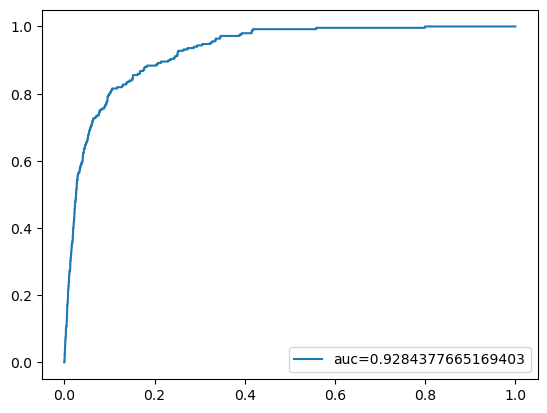

In [36]:
Y.dropna(subset = features, inplace = True)
Y = Y[(Y.year > 1987) & (Y.year < 2022) ]
len(Y)

X = Y[features]
y = Y['Outcome']
from scipy.stats import mstats                                                   #mstats is useful for winsorization
def winsorize_series(group):
    return mstats.winsorize(group, limits=[.05, .05])
features_win = ['DER', 'ROA', 'TLTA', 'FUTL', 'b2m', 'year']
                
#Training data
X_pre2006 = Y[features_win][Y.year<2006].groupby('year')                         #Grouped by 'year' becuase financial ratio distributions vary across years
X_train = X_pre2006.transform(winsorize_series)
y_train = Y['Outcome'].loc[Y.year<2006]

#Test data
X_post2006 = Y[features_win][Y.year>=2006].groupby('year')
X_test = X_post2006.transform(winsorize_series)
y_test = Y['Outcome'].loc[Y.year >= 2006]

# Use SK learn to fit logistic regression.
logreg = LogisticRegression(penalty = 'l2', max_iter=200, random_state=16)    # 'penalty' allows you to run penalized regressions, usful when there are a large number of parameters to be estimated.
# fit the model with training data
logreg.fit(X_train, y_train)

#%% Receiver Operating Characteristic (ROC) curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]                                #Probability of default for the test sample
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc=" + str(auc))                                 #plot false positive rate vs true positive rate for different  thresholds for classification

plt.legend(loc=4)
plt.show()

ROC

### 1.4 comparison the metrics preformance between 0.1 and 0.5 threshold
- **Accuracy**: The accuracy increases as the threshold moves from 0.01 to 0.05, indicating that the model correctly predicts more instances overall as the threshold for declaring bankruptcy is raised. However, in bankruptcy prediction models where class distribution is skewed, accuracy alone might be misleading as it can be inflated by the model's performance on the majority class.

- **Recall**: At the lower threshold of 0.01, the recall is quite high, showing that the model is good at identifying most of the bankrupt cases, which is crucial for a bankruptcy prediction model. The recall decreases as the threshold increases, which suggests that while the model becomes more conservative at predicting bankruptcies, it starts to miss more actual bankrupt cases.

- **Precision**: The precision is low at the 0.01 threshold and increases with the threshold, indicating that as the threshold increases, the model becomes more selective, reducing the number of false positives (i.e., non-bankrupt companies wrongly identified as bankrupt). However, the trade-off is that some bankrupt cases may be missed.

### Justification for choosing a threshold:

- If the cost of missing a bankruptcy is high, a lower threshold like 0.01 might be preferred despite the lower precision because it offers higher recall, meaning the model is more likely to identify potential bankruptcies at the expense of having more false positives.

- A higher threshold, while improving precision and reducing the number of false positives, might be more suitable if the cost of false alarms is high and the model needs to be more certain before flagging a company as potentially bankrupt.

- The best threshold strikes a balance, offering a recall that is sufficiently high to catch most bankruptcies without having an unmanageable number of false positives. This middle ground minimizes both the risk of missing bankruptcies and the cost of false alarms.

In summary, the optimal threshold depends on the specific costs associated with false negatives and false positives in the context of bankruptcy prediction and should be determined in consultation with domain experts.

In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

probs = logreg.predict_proba(X_test) 
y_prediction = pd.DataFrame(probs[::,1], index = y_test.index, columns = ['Predicted_probs'])
Precision_recall = pd.DataFrame(index = range(1, 10),  columns= ["threshold","accuracy", "recall", "precision"])
for i in range (1,10):
        prob_threshold = i/100
        prediction = np.where(y_prediction > prob_threshold, 1, 0)
        Precision_recall.at[i,'threshold'] = prob_threshold
        Precision_recall.at[i,'accuracy'] = accuracy_score(y_test, prediction)
        Precision_recall.at[i,'recall'] = recall_score(y_test, prediction)
        Precision_recall.at[i,'precision'] = precision_score(y_test, prediction)

Precision_recall

,threshold,accuracy,recall,precision
1,0.01,0.852015,0.839357,0.030413
2,0.02,0.921492,0.742972,0.050313
3,0.03,0.948935,0.654618,0.068201
4,0.04,0.963086,0.578313,0.084161
5,0.05,0.971255,0.506024,0.096552
6,0.06,0.976355,0.413655,0.100195
7,0.07,0.979402,0.353414,0.102326
8,0.08,0.982073,0.313253,0.108484
9,0.09,0.98395,0.277108,0.112013


## Task 2: Dow Jones Industrial Average Calculation
---

In [40]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date
from datetime import timedelta

#read the data 
DowJonesStocks = pd.read_excel(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\Dow.xlsx") # reading excel file containing the constituent stocks in the Dow Index
stocks_list = list(DowJonesStocks.Ticker) # passing the symbols to the stocks_list , this list will be input for yfinance data call
d = datetime.timedelta(days = 10)                                               #get data for the last 10 days
data = yf.download(stocks_list, start=date.today()- d, end=date.today()) ##getting prices data using yfinance library
Price = data['Close'].iloc[-1] #extracting last available Close Price for each stock


[*********************100%%**********************]  30 of 30 completed


### 2.1 DJIA Calculation

- **Last Day Close:** Calculation of the Dow Jones Industrial Average as of 2024-02-12 for which data is `0.1517`.

In [42]:
# The closing DJIA value you provided
djia_close_value = 38797.38

sum_of_prices = Price.sum()

# Calculate the DJIA divisor
djia_divisor = sum_of_prices / djia_close_value

# Print the calculated divisor
print(f"The calculated DJIA divisor is: {djia_divisor}")

The calculated DJIA divisor is: 0.15172751530709852


### 2.2 Divisor Adjustment Post-Index Reconstitution

- **Divisor Calculation:** New divisor calculation after INTC is replaced with META in the Dow Jones Industrial Average index.
- **Result:** The new divisor on 2024-02-12 is `0.1626` 

In [44]:
# Remove INTC price and add META price
meta_closing_price = 468.90  
sum_of_prices_before = Price.sum()   
sum_of_prices_after = sum_of_prices_before + - Price['INTC'] +  meta_closing_price  # Remove INTC and Add META price


# Calculate the new DJIA divisor
new_djia_divisor = sum_of_prices_after / djia_close_value

# Print the calculated new divisor
print(f"The new DJIA divisor after reconstitution is: {new_djia_divisor}")

The new DJIA divisor after reconstitution is: 0.16267851254507446
